### 数据获取

In [1]:
'''
获取的基本数据， 和宏观经济指标, 在这里已经进行了ffill处理。
'''
import sys
sys.path.append("/Applications/Wind API.app/Contents/python")
import talib as ta
from WindPy import *
import pandas as pd
import numpy as np
def fetch_wind_data():
    # 启动WindPy接口
    ret = w.start()
    if not ret.ErrorCode == 0:
        raise Exception("WindPy启动失败")
    
    # 检查是否连接成功
    ret = w.isconnected()
    if not ret:
        raise Exception("WindPy未连接")

    # 提取TF和T的初始行情数据
    TF5 = w.wsd('TF.CFE', ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'volume'], '2014-05-05', usedf=True)
    TF = TF5[1].copy()
    TF10 = w.wsd('T.CFE', ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'volume'], '2015-03-20', usedf=True)
    T = TF10[1].copy()
    TL30 = w.wsd('TL.CFE', ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'volume'], '2015-04-22', usedf=True)
    TL = TL30[1].copy()

    '''
    # 宏观数据，开始时间是2014-01-02，初始的缺失值用0填充
    ids = ["S0029657", "S0059749", "S0059744", "S0059747", "M0067855", "G0000886", "G0000889", "G0000891", 
           "G1306752", "G0006352", "G0006353", "M0000612", "M0001227", "M0074417", "M1004524", "M1004520", 
           "M0048486", "M0048488", "M0048490", "M0096868", "M0017142", "M0017141", "M0017145", "M1001854", 
           "S0181383", "S5808575", "S0031525", "M5525763", "M0041653", "M0041652",
           #新加的因子（27个）
          "M1004263","M1004267","M1004271","L4530250","U0737658","O8195887",
            "W6109272","U5267974","Y1667217","W1775339","U9659646","A0239140",
           "F2827408","Z6496161","Y4138099","M0041372","M0041374",
           "M0041378","M0329655","M1004899","M1004900","M1004902",'S0059745',
           'S0059752','M1004264','M1004274','W8696400']
    macro = w.edb(ids, beginTime="2014-01-02", ShowBlank=0, usedf=True)

    #将macro和行情数据拼接在一起
    macro_final = macro[1].copy()
    '''

    T = T.reset_index()
    T = T.rename(columns={'index': 'date'})
    TF= TF.reset_index()
    TF= TF.rename(columns={'index': 'date'})
    TL= TL.reset_index()
    TL= TL.rename(columns={'index': 'date'})   
    
    TF.columns = [col.lower() for col in TF.columns]
    T.columns = [col.lower() for col in T.columns]
    TL.columns = [col.lower() for col in TL.columns]

    '''
    #向前填充macro_final缺失值
    macro_final.replace(0, np.nan, inplace=True)  # Replace 0 with NA for proper forward fill
    macro_final.fillna(method='ffill', inplace=True)    
    macro_final = macro_final.fillna(macro_final.mean())
    macro_final= macro_final.reset_index()
    macro_final= macro_final.rename(columns={'index': 'date'})

    #分别合并TF,T
    merged_TF = pd.merge(TF, macro_final, on='date', how='left') 
    merged_T = pd.merge(T, macro_final, on='date', how='left')
    merged_TL = pd.merge(TL, macro_final, on='date', how='left')
    '''
    w.stop()
    return TF, T, TL


TF_data, T_data, TL_data = fetch_wind_data()

#TF.to_csv("Users/huanghaotian/intern/银河证券/dataset/TF.csv",index=False)
#T.to_csv("Users/huanghaotian/intern/银河证券/dataset/T.csv",index=False)
#TL.to_csv("Users/huanghaotian/intern/银河证券/dataset/TL.csv",index=False)

TF_data.dropna(inplace=True)
T_data.dropna(inplace=True)
TL_data.dropna(inplace=True)

TF_data['date'] = pd.to_datetime(TF_data['date'])
T_data['date'] = pd.to_datetime(T_data['date'])
TL_data['date'] = pd.to_datetime(TL_data['date'])

T_data.tail(10)

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


,date,close,high,low,open,volume
2540,2025-08-27,108.020,108.040,107.865,107.955,99199.0
2541,2025-08-28,107.795,108.005,107.780,107.960,80900.0
2542,2025-08-29,107.810,107.890,107.770,107.795,73717.0
2543,2025-09-01,108.000,108.010,107.700,107.785,84189.0
2544,2025-09-02,107.955,108.015,107.900,108.005,60757.0
2545,2025-09-03,108.160,108.175,108.000,108.015,86857.0
2546,2025-09-04,108.260,108.320,108.215,108.245,83913.0
2547,2025-09-05,107.950,108.240,107.885,108.200,92512.0
2548,2025-09-08,107.865,107.920,107.795,107.860,79696.0
2549,2025-09-09,107.775,107.855,107.755,107.835,69688.0


### 投票信号生成

In [2]:
import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")
#252\10\252 | 504\10\126 都是比较好的搭配
rolling_window = 252    # 阈值调整周期
select_window = 10      # 重新设置因子的周期
back_window = 252  #回溯周期
contract='T' # 合约代码 暂时只支持 T,TF,  TL因为数据不够全，所以跑不了，从wind直接收取的数据只有从2023-04-21开始的
base = 'y'

labels = ['Annualized Return%', 'Sharpe Ratio', 'Max Drawdown%','wining rate%'] # 评价指标
top_n_list = [5, 1, 5, 1]  # 每个标签筛选的top_n因子数量 

#### 技术指标计算

In [3]:
def mom(data, period=10): # 返回的即为指标因子值
    return data['close'] - data['close'].shift(period)   


def cmo(data, period=10): # 返回的即为指标因子值
    delta = data['close'].diff()
    up = delta.apply(lambda x: max(x, 0))  # Up_t
    dn = delta.apply(lambda x: min(x, 0))  # Dn_t

    sum_up = up.rolling(window=period, min_periods=1).sum()
    sum_dn = abs(dn.rolling(window=period, min_periods=1).sum())

    cmo_value = 100 * (sum_up - sum_dn) / (sum_up + sum_dn)
    return cmo_value


def apo(data, short_period=10, long_period=20): # 返回的即为指标因子值
    ma_short = data['close'].rolling(window=short_period).mean()
    ma_long = data['close'].rolling(window=long_period).mean()
    return ma_short - ma_long


def macd(data, short_period=10, long_period=20, signal_period=9):  # 只返回了 hist，用来作为因子值，判断过冷过热等
    def ema(data, period):
        ema = [0] * len(data)  # 初始化 EMA 数组
        multiplier = 2 / (period + 1)
        for i in range(len(data)):
            if i == 0:
                ema[i] = data[i]
            else:
                ema[i] = ((data[i] - ema[i - 1]) * multiplier) + ema[i - 1]
        return ema

    ema_short = ema(data['close'].tolist(), short_period)
    ema_long = ema(data['close'].tolist(), long_period)

    dif = [s - l for s, l in zip(ema_short, ema_long)]
    dea = ema(dif, signal_period)
    hist = [2 * (d - e) for d, e in zip(dif, dea)]

    return hist

def dmi(data, period=10):    # 需要修改因子值，从而去适应后面判断市场状态
    high_diff = data['high'].diff()
    low_diff = -data['low'].diff()
    
    # +DM 和 -DM
    plus_dm = high_diff.where((high_diff > 0) & (high_diff > low_diff), 0.0)
    minus_dm = low_diff.where((low_diff > 0) & (low_diff > high_diff), 0.0)
    
    # 真实波幅 TR
    tr1 = data['high'] - data['low']
    tr2 = abs(data['high'] - data['close'].shift(1))
    tr3 = abs(data['low'] - data['close'].shift(1))
    tr = tr1.combine(tr2, max).combine(tr3, max)
    
    # +DI 和 -DI
    tr_sum = tr.rolling(window=period, min_periods=1).sum()
    plus_di = 100 * (plus_dm.rolling(window=period, min_periods=1).sum() / tr_sum)
    minus_di = 100 * (minus_dm.rolling(window=period, min_periods=1).sum() / tr_sum)
    
    # DX
    dx = 100 * abs((plus_di - minus_di) / (plus_di + minus_di))
    
    # ADX
    adx = dx.rolling(window=period, min_periods=1).mean()
    
    return plus_di, minus_di, adx


def cci(data, period=10):
    tp = (data['high'] + data['low'] + data['close']) / 3
    sma_tp = tp.rolling(window=period, min_periods=1).mean()
    mean_deviation = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci_value = (tp - sma_tp) / (0.015 * mean_deviation)
    return cci_value


def bopa(data, period=20):
    def bop(data):
        return (data['open'] - data['close']) / (data['high'] - data['low'])
    
    bop_values = bop(data)
    return bop_values.rolling(window=period).mean()


def mfi(data, period=10):
    typical_price = (data['high'] + data['low'] + data['close']) / 3
    raw_money_flow = typical_price * data['volume']
    
    positive_flow = []
    negative_flow = []
    
    for i in range(1, len(data)):
        if typical_price[i] > typical_price[i - 1]:
            positive_flow.append(raw_money_flow[i])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i - 1]:
            positive_flow.append(0)
            negative_flow.append(raw_money_flow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_flow = pd.Series(positive_flow).rolling(window=period).sum()
    negative_flow = pd.Series(negative_flow).rolling(window=period).sum()

    money_flow_ratio = positive_flow / negative_flow
    mfi_value = 100 - (100 / (1 + money_flow_ratio))
    
    # 为保持与原始数据对齐，向前填充第一个周期的 NaN 值
    mfi_value = pd.Series([None] + mfi_value.tolist())

    return mfi_value

def aroon(data, period=25):
    aroon_up = 100 * ((period - (period - (data['high'].rolling(window=period).apply(lambda x: list(x).index(max(x)), raw=True)))) / period)
    aroon_down = 100 * ((period - (period - (data['low'].rolling(window=period).apply(lambda x: list(x).index(min(x)), raw=True)))) / period)
    return aroon_up-aroon_down


In [4]:
def bbi(data):
    ma3 = data['close'].rolling(window=3).mean()
    ma6 = data['close'].rolling(window=6).mean()
    ma12 = data['close'].rolling(window=12).mean()
    ma24 = data['close'].rolling(window=24).mean()
    bbi_value = (ma3 + ma6 + ma12 + ma24) / 4
    return bbi_value

def bbi_sig(data):
    bbi_val = data['bbi']
    bbi_sig_value = (bbi_val - bbi_val.shift(1)) / bbi_val.shift(1)
    return bbi_sig_value

# 计算 TR, DMZ, 和 DMF
def dmz_dmf(data):
    tr = data['high'] - data['low']
    dmz = tr.where((data['high'] + data['low']) > (data['high'].shift(1) + data['low'].shift(1)), 0)
    dmf = tr.where((data['high'] + data['low']) < (data['high'].shift(1) + data['low'].shift(1)), 0)
    return tr, dmz, dmf

# 计算 DIZ 和 DIF
def diz_dif(data, period=10):
    tr, dmz, dmf = dmz_dmf(data)
    sum_dmz = dmz.rolling(window=period, min_periods=1).sum()
    sum_dmf = dmf.rolling(window=period, min_periods=1).sum()
    sum_tr = sum_dmz + sum_dmf
    diz = sum_dmz / sum_tr
    dif = sum_dmf / sum_tr
    return diz, dif

# 计算 DDI
def ddi(data, period_dif=10, period_diz=10, period_ddi=10):
    diz, dif = diz_dif(data, period_diz)
    ddi_val = diz - dif
    ddi_sma = ddi_val.rolling(window=period_ddi, min_periods=1).mean()
    return ddi_val

# 计算 ADD 指标
def add(data, period_add=10):
    ddi_vals = data['ddi'].tolist()
    add_vals = []
    for t in range(len(ddi_vals)):
        if t < period_add - 1:
            add_vals.append(None)
        else:
            numerator = sum((11 - i) * ddi_vals[t + 1 - i] for i in range(1, 11))
            denominator = sum(range(1, 11))
            add_vals.append(numerator / denominator)
    return pd.Series(add_vals)

# 计算 AD 指标
def ad(data, period_ad=5):
    add_vals = data['add'].rolling(window=period_ad, min_periods=1).sum()
    return add_vals / period_ad

#  计算 DMA
def dma(data, short_period=10, long_period=20, ama_period=10):
    # 计算短期和长期移动平均线
    ma_short = data['close'].rolling(window=short_period).mean()
    ma_long = data['close'].rolling(window=long_period).mean()
    
    # 计算 DIF
    dif = ma_short - ma_long
    
    # 计算 AMA
    ama = dif.rolling(window=ama_period).mean()
    
    return dif,ama

# 计算 SAR
def sar(data, initial_af=0.02, step_af=0.02, max_af=0.2, accel_period=5):
    sar = [0] * len(data)
    af = initial_af
    uptrend = True

    # 初始化 SAR 和 EP
    ep = data['low'][0] if uptrend else data['high'][0]
    sar[0] = data['low'][0] if uptrend else data['high'][0]
    
    for i in range(1, len(data)):
        prev_sar = sar[i - 1]
        prev_ep = ep
        prev_af = af

        # 判断条件
        if i >= 2 * accel_period:
            cond1 = (i >= accel_period and
                 data['close'][i] > max(data['close'][i - accel_period], data['close'][i - 2 * accel_period]) and
                 data['high'][i] > data['high'][i - 1])
            cond2 = (i >= accel_period and
                 data['close'][i] < min(data['close'][i - accel_period], data['close'][i - 2 * accel_period]) and
                 data['low'][i] < data['low'][i - 1])
        else:
            cond1 = cond2 = False

        # 更新加速因子 AF
        if uptrend:
            if cond1:
                af = min(max_af, prev_af + step_af)
            else:
                af = 0.02
        else:
            if cond2:
                af = min(max_af, prev_af + step_af)
            else:
                af = 0.02

        # 更新极值点 EP
        if uptrend:
            ep = max(prev_ep, data['high'][i])
        else:
            ep = min(prev_ep, data['low'][i])

        # 计算当前 SAR
        sar[i] = prev_sar + prev_af * (ep - prev_sar)

        # 判断反转
        if uptrend:
            if data['low'][i] < sar[i]:
                uptrend = False
                sar[i] = prev_ep
                ep = data['low'][i]
                af = initial_af
            else:
                ep = max(ep, data['high'][i])
        else:
            if data['high'][i] > sar[i]:
                uptrend = True
                sar[i] = prev_ep
                ep = data['high'][i]
                af = initial_af
            else:
                ep = min(ep, data['low'][i])

        # 约束 SAR 的最终值
        if i >= accel_period:
            if uptrend:
                sar[i] = min(sar[i], min(data['low'][i - accel_period:i + 1]))
            else:
                sar[i] = max(sar[i], max(data['high'][i - accel_period:i + 1]))

    return pd.Series(sar)


def trix_and_trma(data):
    close_prices = data['close']
    ax_values = np.zeros(len(close_prices))
    bx_values = np.zeros(len(close_prices))
    trix_values = np.zeros(len(close_prices))
    trma_values = np.zeros(len(close_prices))
    
    # Calculate AX_T
    for t in range(len(close_prices)):
        if t == 0:
            ax_values[t] = 0
        elif t == 1:
            ax_values[t] = (9/11) * close_prices[t-1] + (2/11) * close_prices[t]
        else:
            ax_values[t] = (9/11) * ax_values[t-1] + (2/11) * close_prices[t]
    
    # Calculate BX_T
    for t in range(len(close_prices)):
        if t == 0 or t == 1:
            bx_values[t] = 0
        elif t == 2:
            bx_values[t] = (9/11) * ax_values[0] + (2/11) * ax_values[1]
        else:
            bx_values[t] = (9/11) * bx_values[t-1] + (2/11) * ax_values[t]
    
    # Calculate TRIX_T
    for t in range(len(close_prices)):
        if t < 3:
            trix_values[t] = 0
        elif t == 3:
            trix_values[t] = (9/11) * bx_values[0] + (2/11) * bx_values[1]
        else:
            trix_values[t] = (9/11) * trix_values[t-1] + (2/11) * bx_values[t]
    
    # Calculate TRMA_T
    for t in range(len(close_prices)):
        if t < 9:
            trma_values[t] = 0
        else:
            trma_values[t] = close_prices[t] - np.sum(trix_values[t-9:t+1]) / 10
    
    trix_series = pd.Series(trix_values, index=data.index)
    trma_series = pd.Series(trma_values, index=data.index)
    
    return trix_series, trma_series

def kdj(data, period=9):
    # 计算 RSV
    low_min = data['low'].rolling(window=period, min_periods=1).min()
    high_max = data['high'].rolling(window=period, min_periods=1).max()
    rsv = (data['close'] - low_min) / (high_max - low_min) * 100

    # 初始化 %K 和 %D
    k = [50] * len(rsv)
    d = [50] * len(rsv)

    # 计算 %K 和 %D
    for i in range(1, len(rsv)):
        k[i] = (2 / 3) * k[i - 1] + (1 / 3) * rsv[i]
        d[i] = (2 / 3) * d[i - 1] + (1 / 3) * k[i]

    # 计算 %J
    j = [3 * k[i] - 2 * d[i] for i in range(len(k))]

    return  pd.Series(j)

def rsi(data, period=10):
    # 计算每日价格变化
    delta = data['close'].diff()

    # 将涨幅和跌幅分开计算
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # 计算平均涨幅和平均跌幅
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # 计算 RS 和 RSI
    rs = avg_gain / avg_loss
    rsi_value = 100 - (100 / (1 + rs))

    return rsi_value

def roc(data, period=5):
    n_period_ago = data['close'].shift(period)
    roc_value = (data['close'] - n_period_ago) / n_period_ago *100
    return roc_value

def maroc(data, roc_values, period=10):
    """计算 MAROC 指标"""
    return roc_values.rolling(window=period, min_periods=1).mean()

def bias(data, period=10):
    """计算 BIAS 指标"""
    moving_average = data['close'].rolling(window=period, min_periods=1).mean()
    bias_value = (data['close'] - moving_average) / moving_average * 100
    return bias_value


def osc(data, period=10):
    moving_average = data['close'].rolling(window=period, min_periods=1).mean()
    osc_value = data['close'] - moving_average
    return osc_value
def oscma1(osc_values, period=10):
    weights = [11 - i for i in range(1, period + 1)]
    weight_sum = sum(range(1, period + 1))
    oscma_values = [0] * len(osc_values)

    for t in range(period - 1, len(osc_values)):
        weighted_sum = sum(weights[i] * osc_values[t + 1 - period + i] for i in range(period))
        oscma_values[t] = 100 * weighted_sum / weight_sum

    return oscma_values

def wr(data, period=9):
    highest_high = data['high'].rolling(window=period, min_periods=1).max()
    lowest_low = data['low'].rolling(window=period, min_periods=1).min()
    wr_value = (highest_high - data['close']) / (highest_high - lowest_low)*100 
    return wr_value


In [5]:
def ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

def tema(data, period=9):
    ema1 = ema(data['close'], period)
    ema2 = ema(ema1, period)
    ema3 = ema(ema2, period)
    return 3 * ema1 - 3 * ema2 + ema3

def vhf(data, period=28):
    high_max = data['high'].rolling(window=period).max()
    low_min = data['low'].rolling(window=period).min()
    close_diff = abs(data['close'] - data['close'].shift(period))
    close_diff = close_diff.replace(0, 1e-6)     # Avoid division by zero
    return (high_max - low_min) / close_diff

def cmf(data, period=20):
    mfv = ((data['close'] - data['low']) - (data['high'] - data['close'])) / (data['high'] - data['low']) * data['volume']
    return mfv.rolling(window=period).sum() / data['volume'].rolling(window=period).sum()

def vris(data, period=12):
    return (data['volume'] - data['volume'].shift(period)) / data['volume'].shift(period) * 100

def stochastic_k(data, period=14):
    low_min = data['low'].rolling(window=period).min()
    high_max = data['high'].rolling(window=period).max()
    return 100 * (data['close'] - low_min) / (high_max - low_min)

def stochastic_d(data, k_period=14, d_period=3):
    k = stochastic_k(data, k_period)
    return k.rolling(window=d_period).mean()

def relative_index(data, period=14):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0.0).rolling(window=period).sum()
    loss = -delta.where(delta < 0, 0.0).rolling(window=period).sum()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def cvi(data, period=20):
    daily_volatility = (data['high'] - data['low']) / data['close']
    return daily_volatility.rolling(window=period).sum()

def obv(data):
    obv = ta.OBV(data['close'], data['volume'])
    return obv

def bb_width(data, window=10):
    bb_width = data['close'].rolling(window).std()
    return bb_width

def cmo(data, period=14):
    cmo = ta.CMO(data['close'], period)
    return cmo



In [6]:
def calculate_indicators(data):
    data = data.copy()
    # 计算 10 天动量
    data['mom'] = mom(data, period=10)    

    # 计算 10 天 CMO
    data['cmo'] = cmo(data, period=10)

    # 计算 MA10 - MA20 的 APO
    data['apo'] = apo(data, short_period=10, long_period=20)

    #计算 MACD (MA10 - MA20) 并生成 DIF, DEA 和 HIST
    data['macd']=macd(data)

    # 计算 10天 DMI (其实是两个指标  PDI 和 MDI  ADX和ADXR )
    data['pdi'], data['mdi'], data['adx'] = dmi(data, period=10)     
    # data['adxr'] = (data['adx'] + data['adx'].shift(9)) / 2   # 补充了一个ADXR

    #计算 10 天 CCI
    data['cci'] = cci(data, period=10)

    # 使用 BOP 的 20 天均值生成 BOPA
    data['bopa'] = bopa(data, period=20)

    # 计算 10 天 MFI
    data['mfi'] = mfi(data, period=10)

    # 计算25天的AROON
    data['ao'] = aroon(data, period=25)

    # 第二篇研报的补充的11个因子

    # 计算 BBI
    data['bbi'] = bbi(data)
    data['bbi'] = bbi_sig(data)

    # 计算DDI
    data['ddi'] = ddi(data, period_dif=10, period_diz=10, period_ddi=10)
    data['add'] = add(data, period_add=10)
    data['ad'] = ad(data, period_ad=5)

    # 计算 DMA
    data['dma'], data['ama']= dma(data, short_period=10, long_period=20, ama_period=10)

    # 计算 SAR
    data['sar'] = sar(data)

    # 计算 TRIX 和 TRMA
    data['trix'], data['trma']= trix_and_trma(data)

    #计算 KDJ
    data['kdj'] = kdj(data, period=9)

    #计算 RSI
    data['rsi'] = rsi(data, period=10)

    # 10 天 ROC 和 MAROC
    data['roc'] = roc(data, period=10)
    # data['maroc'] = maroc(data, data['roc'], period=10)

    #计算 10 天 BIAS
    data['bias'] = bias(data, period=10)

    #计算 10 天 OSC
    data['osc']= osc(data, period=10)
    # data['oscma']=oscma1(data['osc'],period=10)

    # 计算 9天 WR
    data['wr'] = wr(data, period=9)

    # 额外补充的因子
    data['tema'] = tema(data)
    data['vhf'] = vhf(data)
    data['cmf'] = cmf(data)
    data['vris'] = vris(data)
    data['k'] = stochastic_k(data)
    data['d'] = stochastic_d(data)
    data['ri'] = relative_index(data)
    data['cvi'] = cvi(data)
    data['obv'] = obv(data)
    data['bb_width'] = bb_width(data)
    data['cmo'] = cmo(data)
    return data

TF_data['date'] = pd.to_datetime(TF_data['date'])
T_data['date'] = pd.to_datetime(T_data['date'])
T_data.reset_index(drop=True, inplace=True)
TF_data.reset_index(drop=True, inplace=True)

T_indicators = calculate_indicators(T_data)
TF_indicators = calculate_indicators(TF_data)

if contract=='T':
    indicators_data = T_indicators
elif contract=='TF':
    indicators_data = TF_indicators
    
indicators_data = indicators_data.reset_index(drop=True)

合计共四十个因子

#### 信号生成

因子挑选

In [7]:
# 选择需要的因子
indicators = [
    "macd", "bbi", "ad", "ama", "pdi","mdi", 'mom',"sar",
    "kdj", "rsi", "roc", "bias", "cci", "osc", "cmo", "apo", 'ao',
    "bopa", "mfi", "wr", 'tema', 'vhf', 'cmf', 'vris', 'k', 'd', 'ri', 'cvi']

##### 为每个指标构建阈值,并生成各个指标的交易信号

In [8]:
import pandas as pd
import numpy as np

# 用于计算初始阈值
def calculate_initial_thresholds(df, indicator):  
    quantiles = df[indicator].quantile([0.3, 0.4, 0.6, 0.7])

    thresholds = {
        'overheat': quantiles[0.7],  # 过热
        'cool': quantiles[0.3],   # 过冷
        'warming_lower': quantiles[0.4], # 转暖 低
        'warming_upper': quantiles[0.6], # 转暖 高
        'cool_lower': quantiles[0.4], # 转冷 低
        'cool_upper': quantiles[0.6]  # 转冷 高
    }
    return thresholds

# 用于优化阈值
def optimize_thresholds(df, indicator, thresholds, window=10): 
    """
    根据市场状态的条件优化阈值。通过遍历百分位数来调节和选择最佳阈值。
    主要优化条件包括发生概率、上涨概率、涨跌比等。

    参数：
    df : DataFrame - 包含历史数据的DataFrame。
    indicator : str - 用于优化阈值的技术指标列名称。
    thresholds : dict - 初始的市场状态阈值。
    window : int - 用于计算未来涨跌的时间窗口。

    返回：
    dict - 优化后的市场状态阈值。
    """
    results = {}
    percentiles = np.arange(0, 101, 1)
    df = df.copy()


    # 限定阈值选取范围
    median = df[indicator].median()
    std = df[indicator].std()
    df = df[(df[indicator] >= median - 3 * std) & (df[indicator] <= median + 3 * std)]#筛除异常值


    # Overheat (Sell)  市场过热，考虑做空
    best_threshold = None
    best_metric = np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None

    for p in percentiles: # 百分比遍历调优
        threshold = np.percentile(df[indicator], p)

        # 条件1：分位数区间
        if threshold < thresholds['overheat']: # 如果小于过热阈值，跳过
            continue 

        #  条件2：发生概率
        df['temp_signal'] = 0 
        df.loc[(df[indicator] > threshold) & (df[indicator].shift(1) <= threshold), 'temp_signal'] = -1#今天相比昨天上穿threshold

        subset = df[df['temp_signal'] == -1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:  # 发生概率小于1%，跳过；控制过热的概率大于1%
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob > 0.5:  # 上涨概率大于50%，跳过；检查当前信号发生后，未来价格上涨的概率是否低于 50%（即市场过热时不应继续上涨）。
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio>1:   # 涨跌比大于1，跳过；通过比较上涨和下跌的比率，来确认市场是否真的处于过热状态。
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric < best_metric: # 过热是做空，取上涨概率和涨跌比之积最小的值作为卖出阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['overheat'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }


    # cool (Buy) 市场过冷，考虑做多
    best_threshold = None
    best_metric = -np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None

    for p in percentiles:

        threshold = np.percentile(df[indicator], p)
        if threshold > thresholds['cool']:
            continue

        df['temp_signal'] = 0
        df.loc[(df[indicator] < threshold) & (df[indicator].shift(1) >= threshold), 'temp_signal'] = 1
        subset = df[df['temp_signal'] == 1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob < 0.5:  # 上涨概率小于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio<1:   # 涨跌比小于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric > best_metric: # 过冷是做多，取上涨概率和涨跌比之积最大的值作为买入阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['cool'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }

    # Turn-Warming (Buy) 市场转暖，考虑做多
    best_threshold = None
    best_metric = -np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None
    
    for p in percentiles:
        threshold = np.percentile(df[indicator], p)
        
        if threshold < thresholds['warming_lower'] or threshold > thresholds['warming_upper']:
            continue

        df['temp_signal'] = 0
        df.loc[(df[indicator] <= thresholds['warming_upper'])&(df[indicator] > threshold) & (df[indicator].shift(1) < df[indicator]), 'temp_signal'] = 1

        subset = df[df['temp_signal'] == 1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob < 0.5:  # 上涨概率小于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio<1:   # 涨跌比小于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric > best_metric: # 转暖是做多，取上涨概率和涨跌比之积最大的值作为买入阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['turn_warm'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }

    # Turning Cool (Sell)
    best_threshold = None
    best_metric = np.inf
    best_up_prob=None
    best_ratio=None
    best_occurrence_prob=None

    
    for p in percentiles:
        threshold = np.percentile(df[indicator], p)
        if threshold < thresholds['cool_lower'] or threshold > thresholds['cool_upper']:
            continue

        df['temp_signal'] = 0
        df.loc[(df[indicator] >= thresholds['cool_lower'])&(df[indicator] < threshold) & (df[indicator].shift(1) > df[indicator]), 'temp_signal'] = -1
        subset = df[df['temp_signal'] == -1]
        occurrence_prob = len(subset) / len(df)
        if occurrence_prob <= 0.01:
            continue

        # 条件3：上涨概率
        future_returns = (df['close'].shift(-window) - df['close']) / df['close']
        future_returns = future_returns.loc[subset.index]
        up_prob = (future_returns > 0).sum() / len(future_returns)

        if up_prob > 0.5:  # 上涨概率大于50%，跳过
            continue

        # 条件4：涨跌比
        down_prob=(future_returns < 0).sum() / len(future_returns)

        up_mean = future_returns[future_returns > 0].mean()
        down_mean = future_returns[future_returns < 0].mean()
        ratio=up_prob * up_mean / ((abs(down_mean) if down_mean != 0 else 1)*(abs(down_prob) if down_prob != 0 else 1))
        if ratio>1:   # 涨跌比大于1，跳过
            continue

        # 对阈值进行优化
        metric = ratio*up_prob

        if metric < best_metric: # 转冷是做空，取上涨概率和涨跌比之积最小的值作为卖出阈值
            best_metric = metric
            best_up_prob=up_prob
            best_ratio=ratio
            best_threshold = threshold
            best_occurrence_prob=occurrence_prob
        else:
            continue

    results['turn_cool'] = {
        'threshold': best_threshold,
        'up_prob':best_up_prob,
        'ratio':best_ratio,
        'metric': best_metric,
        'occurrence_prob': best_occurrence_prob
    }

    return results

# 用于生成信号
def generate_signals(df, indicator, results, thresholds):
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    df['signal'] = 0
    df['condition'] = 'neutral'  # 默认处于中性状态

    # Process 'overheat'
    if results['overheat']['threshold'] is not None:
        threshold = results['overheat']['threshold']
        df.loc[(df[indicator] > threshold), 'signal'] = -1
        df.loc[(df[indicator] > threshold), 'condition'] = 'overheat'

    # Process 'cool'
    if results['cool']['threshold'] is not None:
        threshold = results['cool']['threshold']
        df.loc[(df[indicator] < threshold), 'signal'] = 1
        df.loc[(df[indicator] < threshold), 'condition'] = 'cool'

    # Process 'turn_warm'
    if results['turn_warm']['threshold'] is not None:
        threshold_warm = results['turn_warm']['threshold']
        threshold_overheat = results['overheat']['threshold']
        df.loc[(df[indicator] < threshold_overheat) & 
               (df[indicator] >= threshold_warm), 'signal'] = 1
        df.loc[(df[indicator] < threshold_overheat) & 
               (df[indicator] >= threshold_warm), 'condition'] = 'turn_warm'

    # Process 'turn_cool'
    if results['turn_cool']['threshold'] is not None:
        threshold_cool = results['cool']['threshold']
        threshold_turn_cool = results['turn_cool']['threshold']
        df.loc[(df[indicator] > threshold_cool) & 
               (df[indicator] <= threshold_turn_cool), 'signal'] = -1
        df.loc[(df[indicator] > threshold_cool) & 
               (df[indicator] <= threshold_turn_cool), 'condition'] = 'turn_cool'

    # Generate continuous signals
    df['final_signal'] = df['signal'].copy()
    last_signal = 0
    last_condition = 'neutral'
    started = False

    for i in range(len(df)):
        if df.at[i, 'signal'] != 0:
            last_signal = df.at[i, 'signal']
            last_condition = df.at[i, 'condition']
            started = True
        elif started:
            df.at[i, 'final_signal'] = last_signal
            df.at[i, 'condition'] = last_condition

    return df

# 使用滚动窗口更新阈值和生成信号
def rolling_threshold_update(df, indicators, window=252):
    updated_df = df.copy()

    for indicator in indicators:    
        for i in range(window, len(df)):
            if i % window==0:
                rolling_data = df.iloc[i - window:i].copy()
                thresholds_st = calculate_initial_thresholds(rolling_data, indicator)
                results = optimize_thresholds(rolling_data, indicator, thresholds_st)
                df_with_signals = generate_signals(df.iloc[i:min(i+window,len(df))].copy(), indicator, results, thresholds_st)
            updated_df.loc[i , indicator + '_value'] = df_with_signals.loc[i%window, indicator]
            updated_df.loc[i, indicator + '_sign'] = df_with_signals.loc[i%window, 'final_signal']
            updated_df.loc[i, indicator + '_condition'] = df_with_signals.loc[i%window, 'condition']
    return updated_df

# 示例：通过滚动窗口更新信号并应用
# 滚动窗口更新信号并应用
import os
# 设置文件路径
file_path = f'rolling_data_{contract}_{rolling_window}.csv'
# 检查文件是否存在
if not os.path.exists(file_path):
    # 如果文件不存在，运行滚动窗口更新信号并应用
    rolling_signal = rolling_threshold_update(indicators_data, indicators, window=rolling_window)
    
    # 将结果保存到 CSV 文件
    rolling_signal.to_csv(file_path, index=False)
    print(f"滚动信号已生成并保存为 {file_path}")
else:
    # 如果文件已存在，加载已保存的数据
    rolling_signal = pd.read_csv(file_path)
    rolling_signal['date'] = pd.to_datetime(rolling_signal.date)
    print(f"已加载现有的滚动信号数据：{file_path}")


rolling_signal['y'] = (rolling_signal['close']-rolling_signal['open'])/rolling_signal['open']*100   # 当日的收-开
rolling_signal['y2'] = (rolling_signal['open'].shift(-1)-rolling_signal['open'])/rolling_signal['open']*100# 第二天的开-当日开 

已加载现有的滚动信号数据：rolling_data_T_252.csv


##### 单因子训练集回测结果 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def financial_analysis_tech(df, indicators, base):
    df_copy = df.copy()
    
    # 转换收益率 y 为 1 或 -1 
    df_copy['y_acc'] = (df_copy[base] > 0).astype(int)
    df_copy['y_acc'] = df_copy['y_acc'].replace(0, -1)

    results = {
        'Indicator': [],
        'Cumulative Returns': [],
        'Real Returns':[],
        'Annualized Return%': [],
        'Sharpe Ratio': [],
        'Max Drawdown%': [],
        'wining rate%':[]
    }
    
    df_backup = df_copy.copy()
    trading_days = 252
    cumulative_returns_df = pd.DataFrame({'date': df_copy['date']})
    
    
    for indicator in indicators:
        if 'Ensemble' not in indicator:
            indicator = indicator + '_sign'

        cumulative_returns_df[indicator+'_position']=df_copy[indicator]
        df_copy = df_backup.copy()
        df_copy[indicator] = df_copy[indicator].shift(1) # 信号延迟一天，从而避免未来数据
        df_copy.dropna(subset=[indicator], inplace=True)
        
        # 计算准确度
        correct = 0
        for pred, true in zip(df_copy[indicator], df_copy['y_acc']):
            # 预测正确，即做多：1，反之，预测错误：-1
            if pred == true:
                correct += 1
                
        accuracy = correct / len(df_copy[base])*100
        
        # 计算收益
        if base=='y':
            df_copy['net_value']=((df_copy['close']-df_copy['open'])*df_copy[indicator])
            df_copy['returns'] = df_copy['y'] / 100 * df_copy[indicator]
        elif base=='y2':
            df_copy['y2'] = df_copy['y2'].fillna(method='ffill')  # 最后一天的y2为空，填充为前一天的
            df_copy['net_value']=((df_copy['open'].shift(-1)-df_copy['open'])*df_copy[indicator])
            df_copy['returns'] = df_copy['y2'] / 100 * df_copy[indicator]


        # 汇总单因子回测结果

        indicator=indicator.split('_')[0]

        # cumulative returns
        df_copy['cumulative_returns'] = (1 + df_copy['returns']).cumprod()
        cumulative_returns_df[indicator] = df_copy['cumulative_returns']


        # annualized return
        annualized_return = df_copy['cumulative_returns'].iloc[-1]**(trading_days / len(df_copy)) - 1
        
        # Sharpe ratio (Assuming risk-free rate = 0 for simplicity)
        sharpe_ratio = annualized_return / ((df_copy['returns'].std()+0.000001) * (trading_days**0.5))
        
        #  maximum drawdown
        rolling_max = df_copy['cumulative_returns'].cummax()
        drawdown = (df_copy['cumulative_returns'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
       
        results['Indicator'].append(indicator.upper())
        results['Cumulative Returns'].append(df_copy['cumulative_returns'].iloc[-1])
        results['Annualized Return%'].append(annualized_return*100)
        results['Sharpe Ratio'].append(sharpe_ratio)
        results['Max Drawdown%'].append(max_drawdown*100)
        results['Real Returns'].append(df_copy['net_value'].sum())
        results['wining rate%'].append(accuracy)
        
  
    results_df = pd.DataFrame(results)
    cumulative_returns_df['date'] = pd.to_datetime(cumulative_returns_df['date'])
    """
    # 绘制所有因子的净值曲线图
    plt.figure(figsize=(14, 7))
    for indicator in indicators:
        plt.plot(cumulative_returns_df['date'], cumulative_returns_df[indicator], label=indicator.upper())
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    
    return results_df, cumulative_returns_df

#### 因子筛选

In [10]:
def rolling_factor_selection(df, indicators, base, labels, top_n_list, window=10,back_window=252):
    """
    根据滚动窗口逐步筛选最优的技术指标因子，动态更新选择的因子。
    
    参数：
    df : DataFrame - 包含历史数据的DataFrame。
    indicators : list - 技术指标列表。
    base : str - 用于计算收益的列名（如'y'或'y2'等）。
    labels : list - 用于排序的列名列表（如'wining rate%'，'Cumulative Returns'等）。
    top_n_list : list - 每个label对应的筛选个数列表，决定每个因子选择的个数。
    window : int - 滚动窗口的大小（默认为252，即一年）。
    
    返回：
    selected_indicators : list - 滚动筛选出来的技术指标因子。
    """
    selected_indicators = {}  # 使用集合避免重复

    for i in range(window+rolling_window, len(df)):
        if (i-rolling_window)%window==0:
            rolling_data = df.iloc[i+1-back_window:i+1].copy()  # 获取当前窗口的数据

            results_df, _ = financial_analysis_tech(rolling_data, indicators, base)  # 根据滚动窗口数据生成因子的回测结果
            
            # 针对每个标签和对应的top_n，筛选因子
            for label, top_n in zip(labels, top_n_list):
                if top_n == -1:
                    top_n = len(results_df)  # 如果top_n为-1，选择所有因子
                
                sorted_df = results_df.sort_values(by=label, ascending=False).reset_index(drop=True)
                top_indicators = []
                for j in range(top_n):
                    top_indicators+=[sorted_df.loc[j,'Indicator']]*(top_n-j)

                # 使用 set 来确保没有重复的因子
                selected_indicators_set = selected_indicators.get((i-rolling_window) // window - 1, [])  # 获取已选择的因子集合
                selected_indicators_set += top_indicators  # 将新选出的因子加入集合
                selected_indicators[(i-rolling_window) // window - 1] = list(selected_indicators_set)  # 更新selected_indicators为无重复值的列表
        
    return selected_indicators  # 返回最终选中的因子列表

# 使用滚动方式选择技术指标
selected_indicators_dict = rolling_factor_selection(rolling_signal, indicators, base, labels, top_n_list, window=select_window, back_window=back_window)
print("Selected indicators:", selected_indicators_dict)


Selected indicators: {0: ['MFI', 'MFI', 'MFI', 'MFI', 'MFI', 'PDI', 'PDI', 'PDI', 'PDI', 'VRIS', 'VRIS', 'VRIS', 'VHF', 'VHF', 'TEMA', 'MFI', 'MACD', 'MACD', 'MACD', 'MACD', 'MACD', 'AMA', 'AMA', 'AMA', 'AMA', 'SAR', 'SAR', 'SAR', 'APO', 'APO', 'MFI', 'PDI'], 1: ['MFI', 'MFI', 'MFI', 'MFI', 'MFI', 'PDI', 'PDI', 'PDI', 'PDI', 'TEMA', 'TEMA', 'TEMA', 'CCI', 'CCI', 'VRIS', 'MFI', 'MACD', 'MACD', 'MACD', 'MACD', 'MACD', 'AMA', 'AMA', 'AMA', 'AMA', 'SAR', 'SAR', 'SAR', 'APO', 'APO', 'MFI', 'MFI'], 2: ['CCI', 'CCI', 'CCI', 'CCI', 'CCI', 'TEMA', 'TEMA', 'TEMA', 'TEMA', 'CMF', 'CMF', 'CMF', 'BBI', 'BBI', 'CMO', 'CCI', 'MACD', 'MACD', 'MACD', 'MACD', 'MACD', 'AMA', 'AMA', 'AMA', 'AMA', 'SAR', 'SAR', 'SAR', 'APO', 'APO', 'TEMA', 'MFI'], 3: ['MFI', 'MFI', 'MFI', 'MFI', 'MFI', 'CCI', 'CCI', 'CCI', 'CCI', 'CMF', 'CMF', 'CMF', 'TEMA', 'TEMA', 'AD', 'MFI', 'MACD', 'MACD', 'MACD', 'MACD', 'MACD', 'AMA', 'AMA', 'AMA', 'AMA', 'SAR', 'SAR', 'SAR', 'APO', 'APO', 'AO', 'MFI'], 4: ['MFI', 'MFI', 'MFI', 'MFI

#### 技术指标信号回测

In [11]:
def rolling_generate_new_signal(rolling_signal, selected_indicators, threshold=0.5, window=10):
    """
    根据滚动窗口内的技术指标因子进行投票生成Ensemble信号。
    
    参数：
    rolling_signal : DataFrame - 包含历史数据的滚动信号 DataFrame。
    selected_indicators : list - 选择的技术指标因子列表。
    threshold : float - 投票阈值，默认值为0.5。
    window : int - 滚动窗口的大小，默认为252（即一年）。
    
    返回：
    combined_signals2 : DataFrame - 带有生成的Ensemble信号的DataFrame。
    """
    combined_signals2 = rolling_signal.copy()  # 复制数据
    
    def calculate_signal(row, threshold):
        value_counts = row.value_counts()
        most_common_value = value_counts.idxmax()
        most_common_count = value_counts.max()
        if most_common_count / len(row) > threshold:  # 如果投票最多的值超过阈值，返回该值
            return most_common_value
        else:
            return 0  # 否则返回0，表示不确定信号

    # 遍历数据，进行滚动窗口计算
    for i in range(window+rolling_window, len(rolling_signal)):
        if (i-rolling_window)%window==0:
            # 获取当前窗口的数据
            indicator_s = selected_indicators[(i-rolling_window)//window-1]
            indicator_s = [i.lower()+'_sign' for i in indicator_s]

        # 基于选中的指标因子计算投票结果
        row = rolling_signal.loc[i,indicator_s]  # 当前窗口的信号
        signal = calculate_signal(row , threshold)

        # 将投票结果保存到DataFrame中
        combined_signals2.at[i, 'Ensemble'] = signal # 仅保存窗口内最后一条记录的投票结果

    return combined_signals2

# 使用滚动窗口生成新的Ensemble信号
combined_signals2 = rolling_generate_new_signal(rolling_signal, selected_indicators_dict, threshold=0.5, window=select_window)

# 查看生成的新信号
display(combined_signals2)

indicators+=['Ensemble']
r_df ,cumulative_returns_df= financial_analysis_tech(combined_signals2, indicators,base)

,date,close,high,low,open,volume,mom,cmo,apo,macd,...,ri_condition,cvi_value,cvi_sign,cvi_condition,obv_value,obv_sign,obv_condition,y,y2,Ensemble
0,2015-03-20,97.090,97.960,96.530,96.900,3332.0,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196078,0.201238,NaN
1,2015-03-23,97.020,97.095,96.840,97.095,1386.0,NaN,-100.000000,NaN,-0.009697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.077244,0.041197,NaN
2,2015-03-24,96.920,97.220,96.875,97.135,1380.0,NaN,-100.000000,NaN,-0.028621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.221341,-0.118392,NaN
3,2015-03-25,96.850,97.030,96.760,97.020,1234.0,NaN,-100.000000,NaN,-0.047509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.175222,-0.190682,NaN
4,2015-03-26,96.370,96.890,96.370,96.835,1073.0,NaN,-100.000000,NaN,-0.121764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.480198,-0.552486,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,2025-09-03,108.160,108.175,108.000,108.015,86857.0,0.305,20.000000,-0.19025,0.068473,...,cool,0.036827,1.0,cool,4607557.0,1.0,cool,0.134241,0.212933,1.0
2546,2025-09-04,108.260,108.320,108.215,108.245,83913.0,0.260,17.567568,-0.14650,0.105659,...,cool,0.036877,1.0,cool,4691470.0,1.0,cool,0.013857,-0.041572,1.0
2547,2025-09-05,107.950,108.240,107.885,108.200,92512.0,0.290,20.000000,-0.08300,0.081139,...,cool,0.038969,1.0,cool,4598958.0,1.0,cool,-0.231054,-0.314233,1.0
2548,2025-09-08,107.865,107.920,107.795,107.860,79696.0,-0.085,-6.827309,-0.06000,0.052578,...,cool,0.038376,1.0,cool,4519262.0,1.0,cool,0.004636,-0.023178,1.0


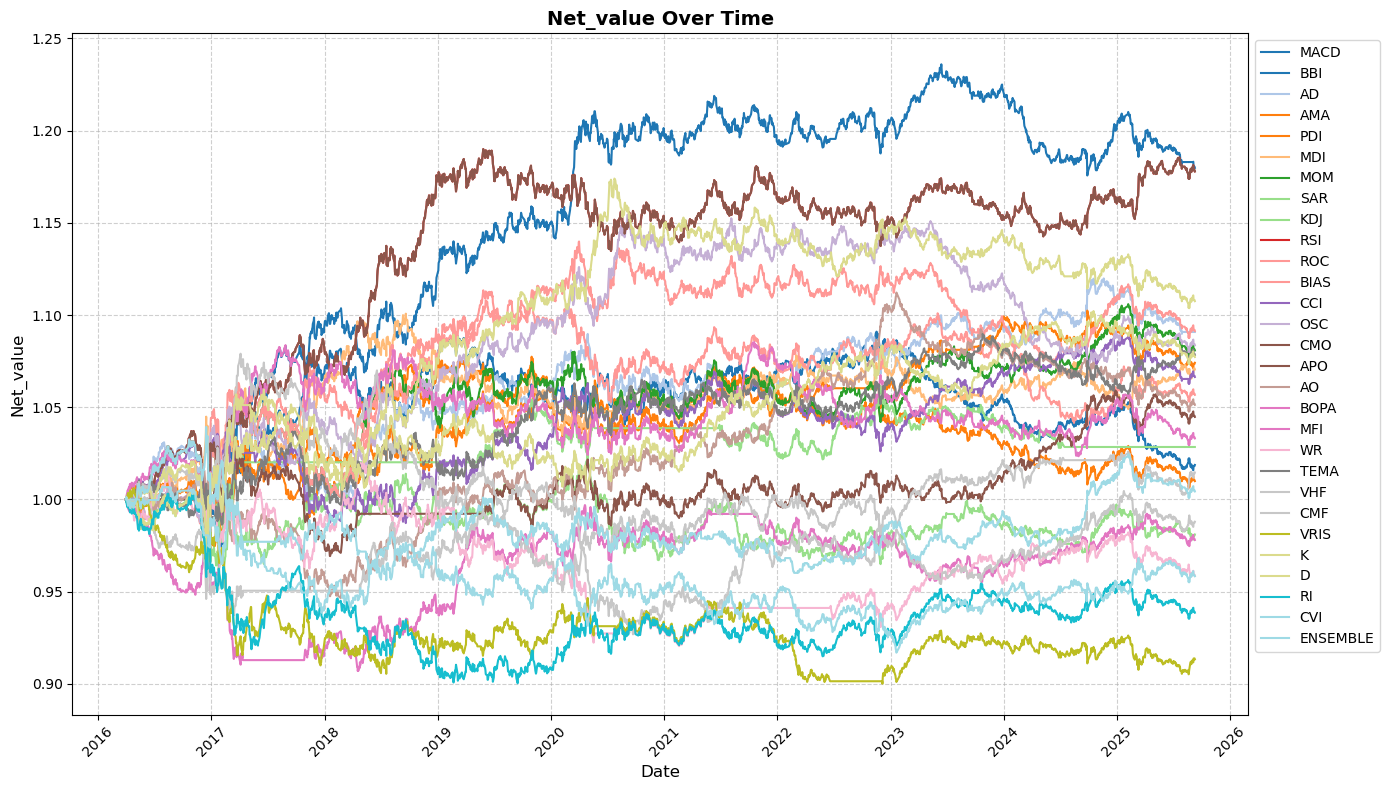

In [12]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'  # 设置字体
plt.figure(figsize=(14, 8))  # 设置图像大小

# 使用颜色区分每条曲线
colors = plt.cm.get_cmap('tab20', len(indicators))  # 使用tab10颜色映射，确保足够的颜色区分
cumulative_returns_plot = cumulative_returns_df
for idx, indicator in enumerate(indicators):
    # 选择颜色并绘制曲线
    plt.plot(cumulative_returns_plot['date'], cumulative_returns_plot[indicator], 
             label=indicator.upper(), color=colors(idx))

# 设置标签和标题
plt.xlabel('Date', fontsize=12)
plt.ylabel('Net_value', fontsize=12)
plt.title('Net_value Over Time', fontsize=14, weight='bold')

# 优化图例，避免颜色重复
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.6)

# 设置日期格式（可选，若需要可以调整）
plt.xticks(rotation=45)

# 展示图像
plt.tight_layout()  # 自动调整布局
plt.show()


考虑增加止损

### 回测结果

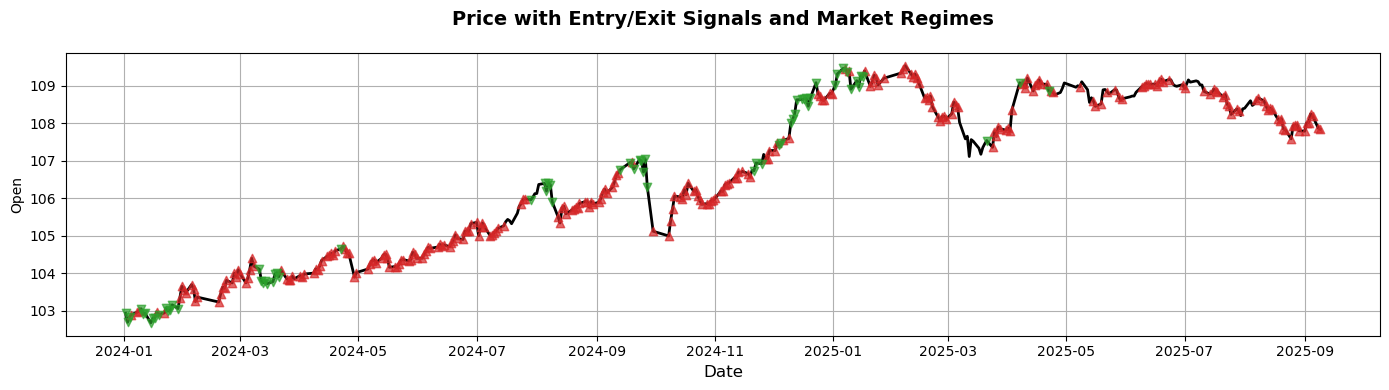

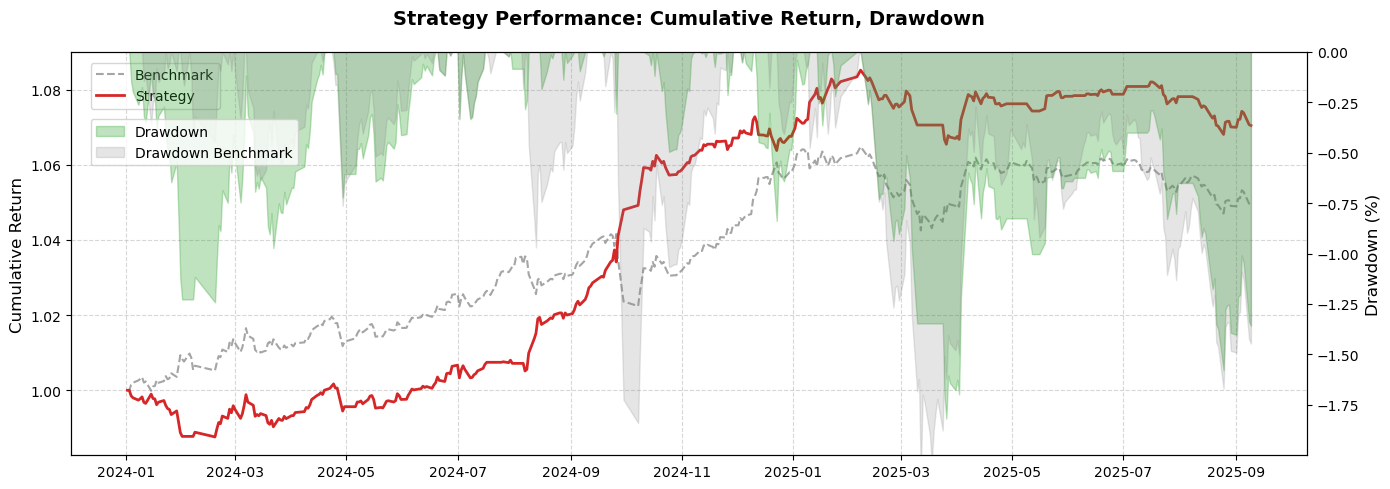

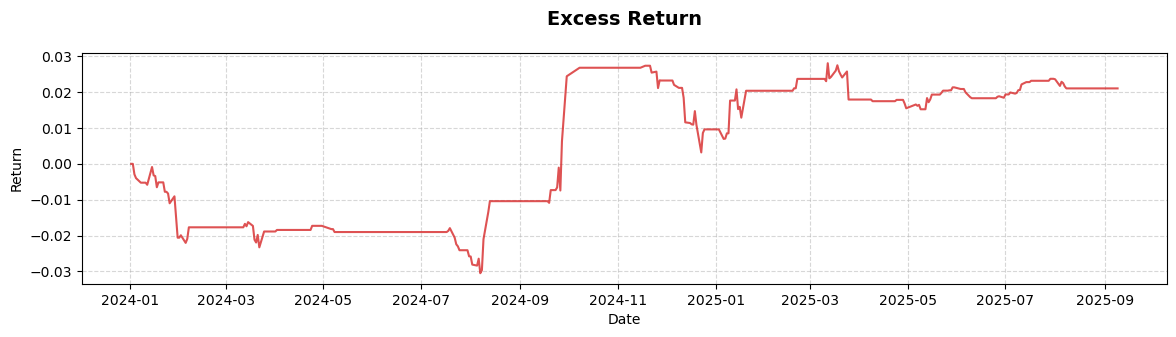

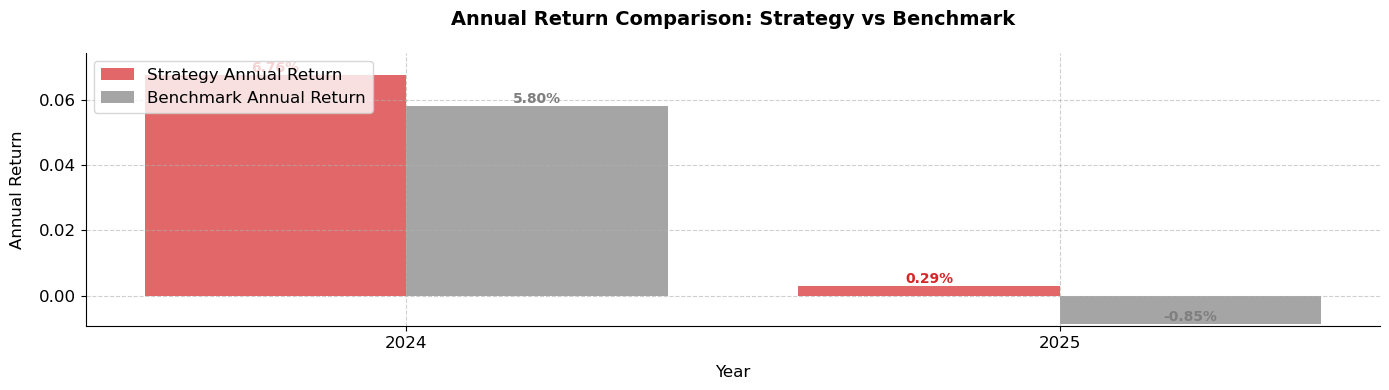

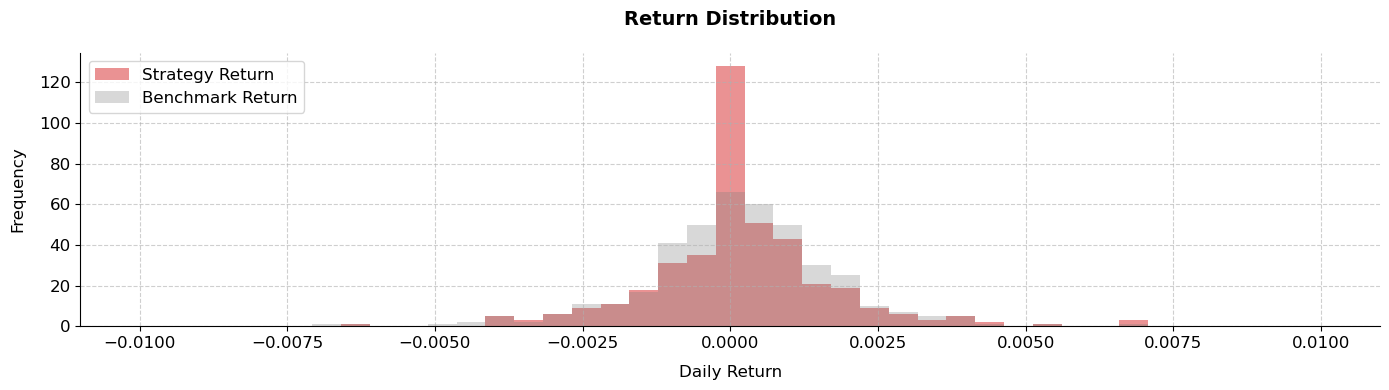

,date,Ensemble
0,2024-01-02,-1.0
1,2024-01-03,-1.0
2,2024-01-04,-1.0
3,2024-01-05,1.0
4,2024-01-08,1.0
...,...,...
405,2025-09-03,1.0
406,2025-09-04,1.0
407,2025-09-05,1.0
408,2025-09-08,1.0


,Cummulative Return,Annual Return,Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Win Rate,Profit Factor
value,0.070447,0.04273,0.024051,1.776638,-0.018182,2.350138,0.561562,1.413116


In [13]:
from Backtrader import StrategyBacktester
import datetime
np.random.seed(0)


backtester = StrategyBacktester(combined_signals2, 
                                start_year=2024, 
                                end_year=2025, 
                                signal_column='Ensemble',
                                price_column='open', 
                                initial_capital=1e9, 
                                rf=0., 
                                slippage=0.,
                                daily_stop_loss_rate=0.007,#相对
                                weekly_stop_loss=0.6  #绝对止损
                                )

# 执行回测
backtester.run_backtest()

# 可视化价格与信号点
backtester.plot_price_with_signals()

# 可视化策略 vs 基准净值
backtester.plot_pnl_curve()

display(backtester.result[['date','Ensemble']])
# 输出绩效指标
display(backtester.evaluate_performance())

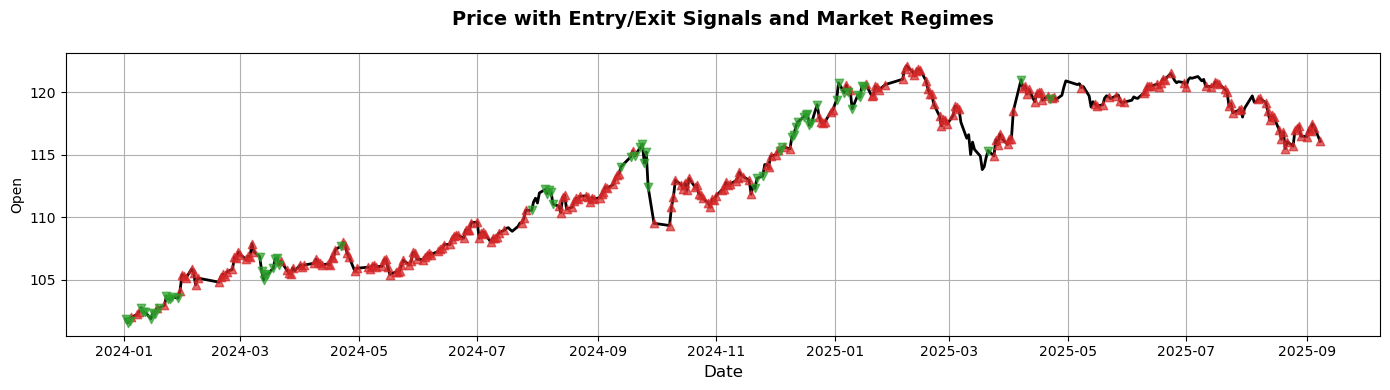

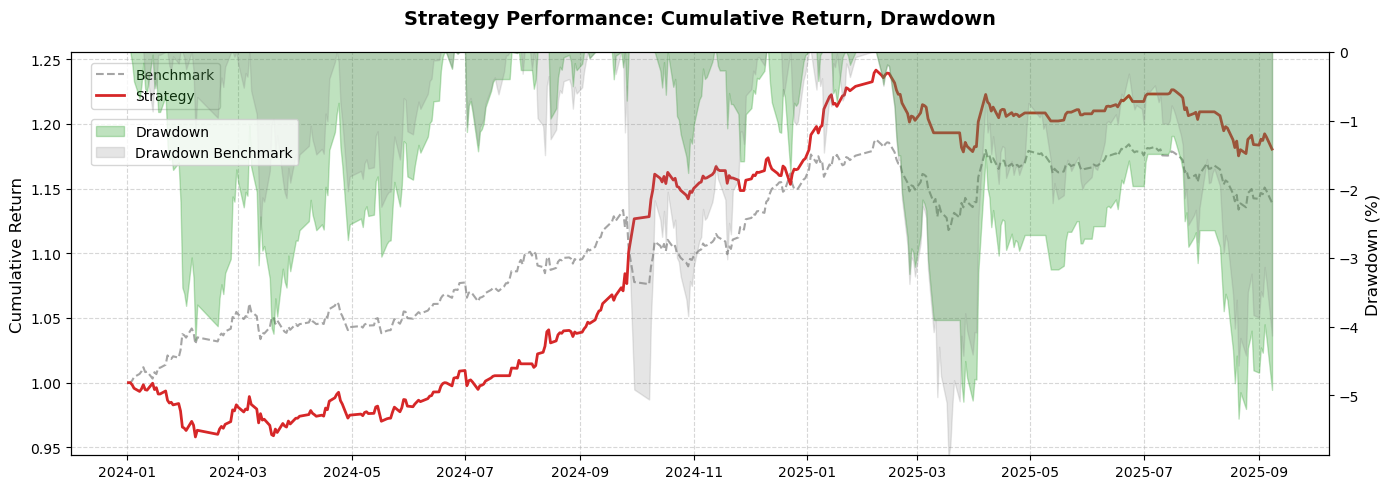

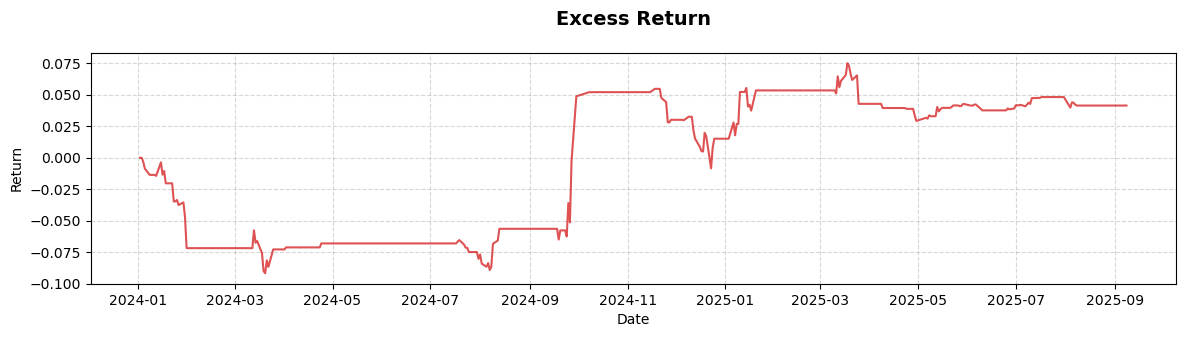

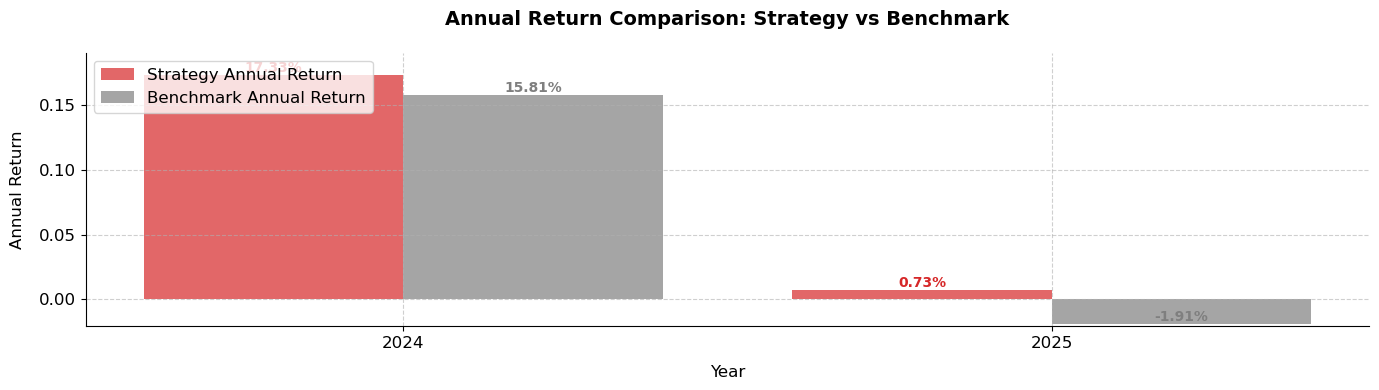

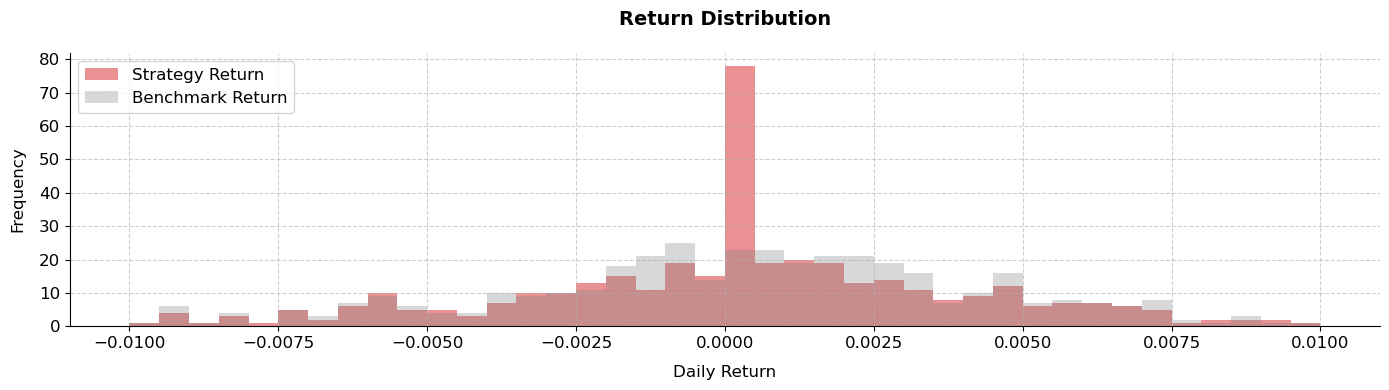

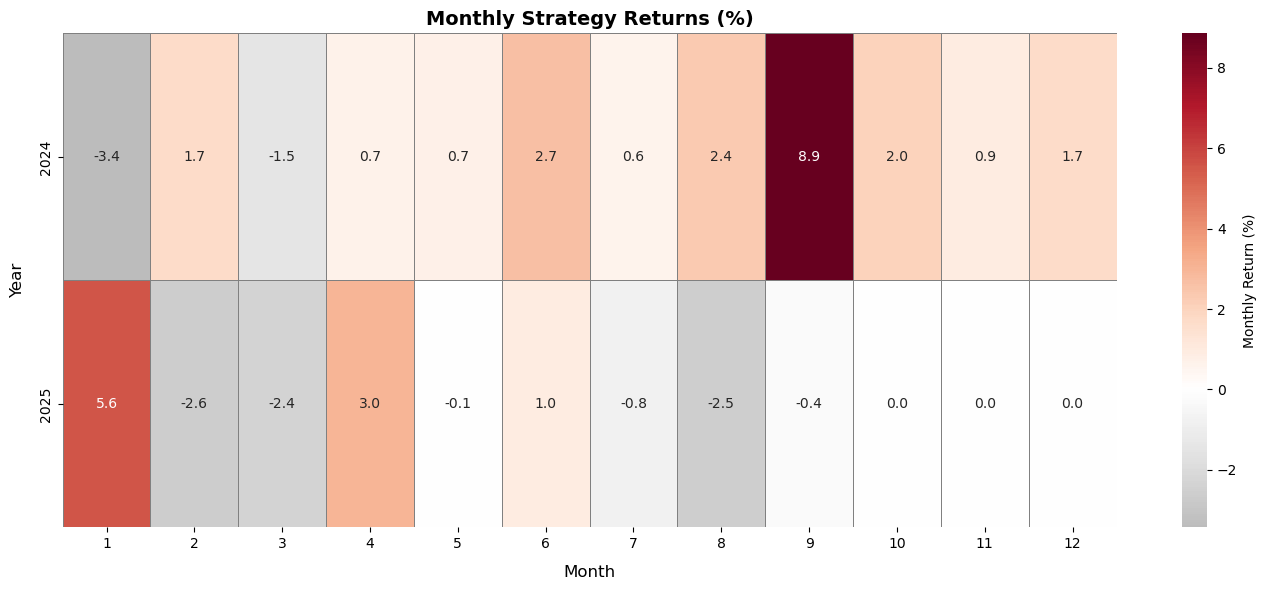

In [14]:
file_path = f'signal_data_TL.csv'# 如果文件已存在，加载已保存的数据
TL_data = pd.read_csv(file_path)
TL_data['date'] = pd.to_datetime(TL_data.date)
TL_signal = combined_signals2[['date','Ensemble']].merge(
    TL_data, 
    left_on='date', 
    right_on='date', 
    how='inner',  # 'inner' 保证只保留那些在两个 DataFrame 中都有的日期
)


#设置日期
test_start_year =2024
test_end_year = 2025

backtester = StrategyBacktester(TL_signal, 
                                start_year=test_start_year, 
                                end_year=test_end_year, 
                                signal_column='Ensemble',
                                price_column='open', 
                                initial_capital=1e9, 
                                rf=0., 
                                slippage=0.
                                )

# 执行回测
backtester.run_backtest()

# 可视化价格与信号点
backtester.plot_price_with_signals()

# 可视化策略 vs 基准净值
backtester.plot_pnl_curve()
backtester.plot_monthly_heatmap_by_year()

### 参数探究

In [15]:
'''
indicators_list = [
    "macd", "bbi", "ad", "ama", "pdi","mdi", 'mom',"sar",
    "kdj", "rsi", "roc", "bias", "cci", "osc", "cmo", "apo", 'ao',
    "bopa", "mfi", "wr", 'tema', 'vhf', 'cmf', 'vris', 'k', 'd', 'ri', 'cvi']



# 初始化数据存储，用于存储每个 top_n_list 对应的 Annual Return
bwlist = []  # 存储top_n_list组合
annual_returns = []  # 存储每个组合的年化回报


for select_window in range(3, 41):
                
                # 运行因子筛选和生成新信号
                selected_indicators_dict = rolling_factor_selection(rolling_signal, indicators_list, base, labels, top_n_list, select_window, back_window)
                combine_signal = rolling_generate_new_signal(rolling_signal, selected_indicators_dict, 0.5, select_window,back_window)
                
                # 执行回测
                backtester = StrategyBacktester(combine_signal, 
                                                start_year=2022, 
                                                end_year=2025, 
                                                signal_column='Ensemble',
                                                price_column='close', 
                                                initial_capital=1e9, 
                                                rf=0., 
                                                slippage=0.)
                backtester.run_backtest()
                
                # 获取年化回报
                annual_return = backtester.evaluate_performance()['Annual Return']
                bwlist.append(back_window)
                annual_returns.append(annual_return)


'''

'\nindicators_list = [\n    "macd", "bbi", "ad", "ama", "pdi","mdi", \'mom\',"sar",\n    "kdj", "rsi", "roc", "bias", "cci", "osc", "cmo", "apo", \'ao\',\n    "bopa", "mfi", "wr", \'tema\', \'vhf\', \'cmf\', \'vris\', \'k\', \'d\', \'ri\', \'cvi\']\n\n\n\n# 初始化数据存储，用于存储每个 top_n_list 对应的 Annual Return\nbwlist = []  # 存储top_n_list组合\nannual_returns = []  # 存储每个组合的年化回报\n\n\nfor select_window in range(3, 41):\n\n                # 运行因子筛选和生成新信号\n                selected_indicators_dict = rolling_factor_selection(rolling_signal, indicators_list, base, labels, top_n_list, select_window, back_window)\n                combine_signal = rolling_generate_new_signal(rolling_signal, selected_indicators_dict, 0.5, select_window,back_window)\n\n                # 执行回测\n                backtester = StrategyBacktester(combine_signal, \n                                                start_year=2022, \n                                                end_year=2025, \n                                        

In [16]:
'''
# 将数据转换为 numpy 数组进行三维绘制
bwlist = np.array(list(range(3,41)))
annual_returns = np.array(annual_returns)
fig = plt.figure()
plt.plot(bwlist, annual_returns)
'''

'\n# 将数据转换为 numpy 数组进行三维绘制\nbwlist = np.array(list(range(3,41)))\nannual_returns = np.array(annual_returns)\nfig = plt.figure()\nplt.plot(bwlist, annual_returns)\n'